In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pyspark.ml import Pipeline
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import SVMWithSGD
from pyspark.mllib.tree import RandomForest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, Word2Vec, Tokenizer, StringIndexer, CountVectorizer, IDF,IndexToString,StopWordsRemover

In [7]:
#basics
import numpy as np
import pandas as pd
import json
import re
from collections import defaultdict
from datetime import datetime

#misc
import gc
import time
import warnings


#viz
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 


#map section
import imageio


#graph section
import networkx as nx
import heapq 

In [8]:
# create Spark session
spark = SparkSession.builder.appName('Yelpreview').getOrCreate()

# change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '32g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '16'), ('spark.cores.max', '16'), ('spark.driver.memory','32g')])

# print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.cores.max', '16'),
 ('spark.ui.proxyBase', '/proxy/application_1643652317966_14648'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.

In [1]:
# hdfs dfs put
review = spark.read.json("/user/xiaoqin/data/data/yelp_academic_dataset_review.json")

In [4]:
# hdfs dfs put
business = spark.read.json("/user/xiaoqin/data/data/yelp_academic_dataset_business.json")

In [11]:
# business.createOrReplaceTempView("business")
print(business.printSchema())
business.show(5)

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [12]:
business.describe().show(5)

+-------+-----------------+--------------------+--------------------+-----------+------------------+-----------------+------------------+--------------------+------------------+------------------+------------------+------+
|summary|          address|         business_id|          categories|       city|           is_open|         latitude|         longitude|                name|       postal_code|      review_count|             stars| state|
+-------+-----------------+--------------------+--------------------+-----------+------------------+-----------------+------------------+--------------------+------------------+------------------+------------------+------+
|  count|           150346|              150346|              150243|     150346|            150346|           150346|            150346|              150346|            150346|            150346|            150346|150346|
|   mean|7369.333333333333|                null|                null|       null|0.7961502135075094| 36.6711

In [13]:
business.count()

150346

In [5]:
business.dropDuplicates().count()

150346

In [2]:
review.count()

6990280

In [3]:
review.dropDuplicates().count()

6990280

In [14]:
business.columns

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [15]:
business.dropna().count()

117618

In [16]:
business = business.dropna()

In [17]:
df1 = business.toPandas()

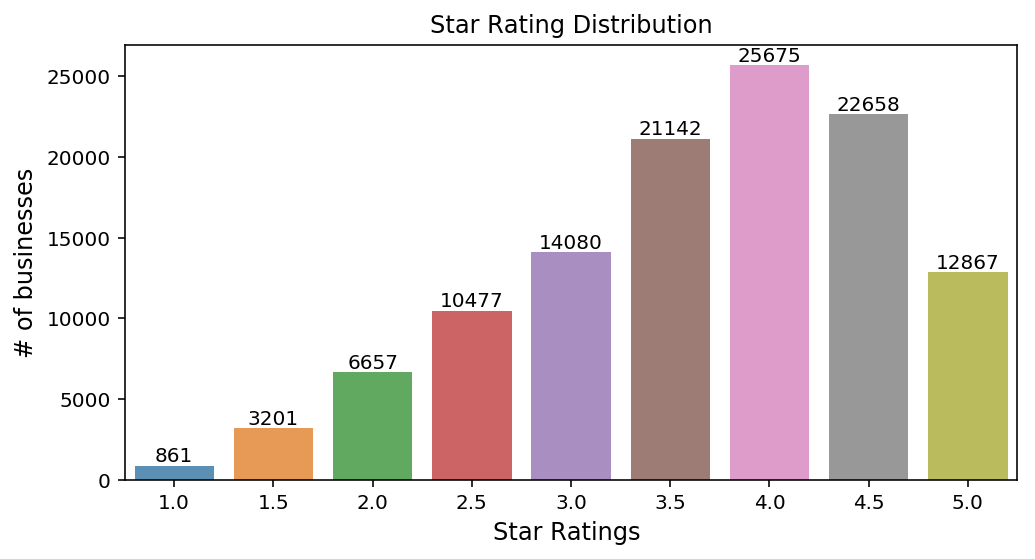

In [18]:
# star Rating Distribution

x = df1["stars"].value_counts().sort_index()
# plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=x.index,y=x.values,alpha=0.8) #Returns the Axes object
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

# add text label
rects = ax.patches
labels = x.values
for rect,label in zip(rects,labels):
    height = rect.get_height()
    ax.text(x=rect.get_x() + rect.get_width()/2,y=height+5,s=label,ha="center",va="bottom")
plt.show()

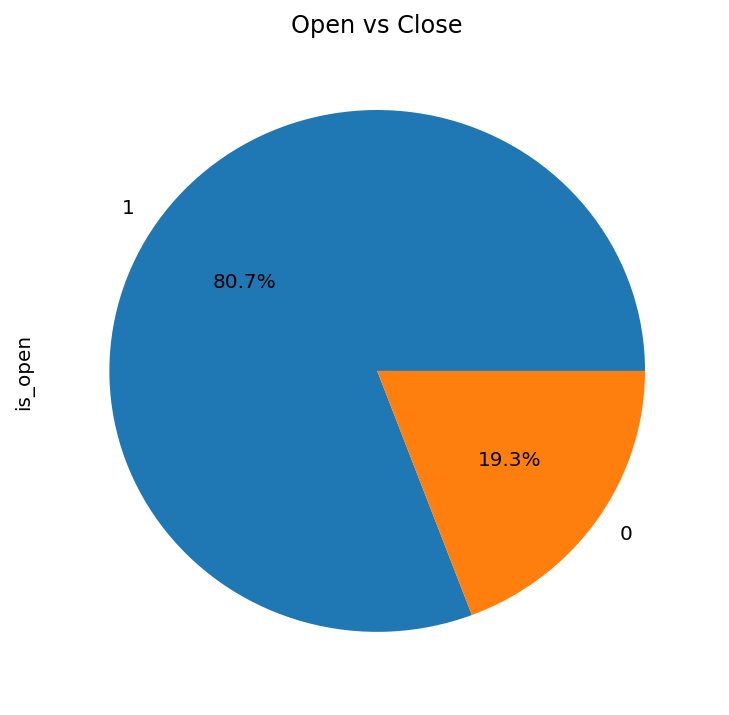

In [19]:
plt.figure(figsize=(6,6))
df1["is_open"].value_counts().plot(kind="pie",autopct='%1.1f%%')
plt.title("Open vs Close")
plt.show()

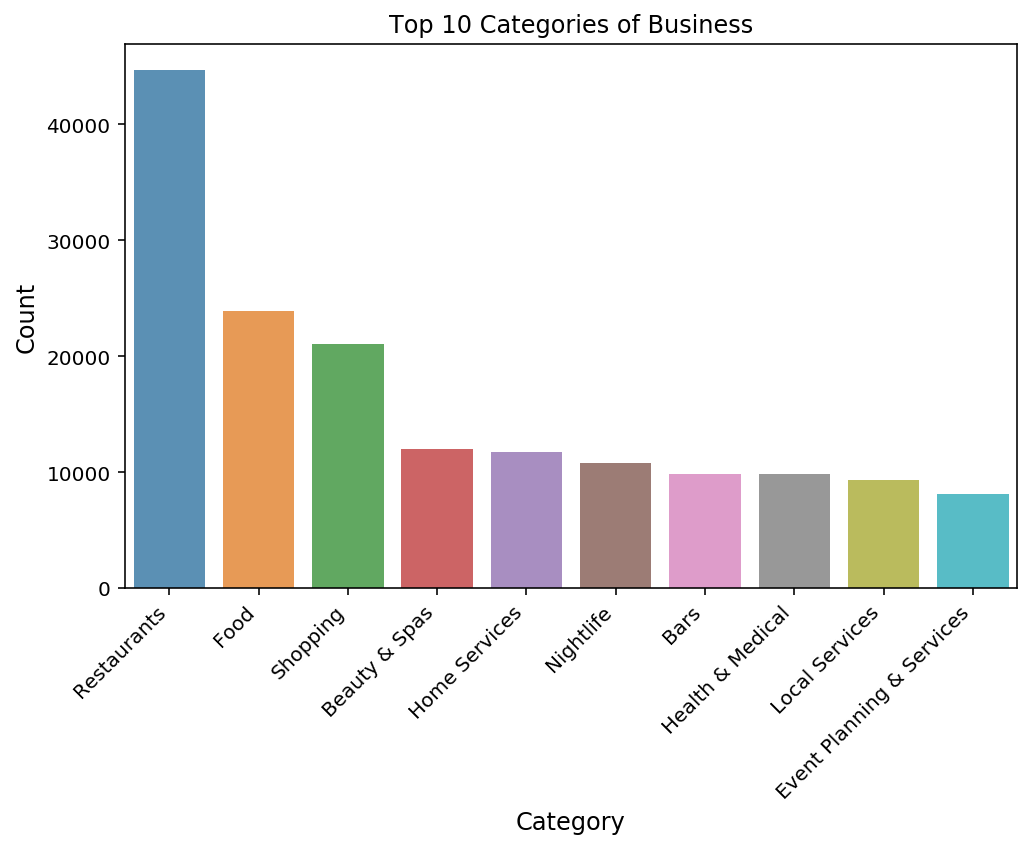

In [20]:
cats = df1["categories"].str.split(",").values #array of lists
cats = pd.Series([c.strip() for l in cats for c in l]) 
top10 = cats.value_counts().sort_values(ascending=False)[:10]
plt.figure(figsize=(8,5))
ax = sns.barplot(x=top10.index,y=top10.values,alpha=0.8)
plt.title("Top 10 Categories of Business")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=45,ha="right")
plt.show()

Since restaurant is the category with highest number of businesses, we decided to only focus on restaurants.

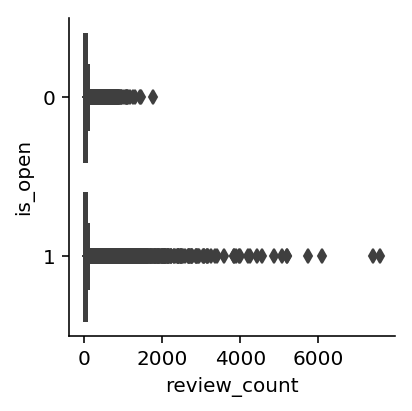

In [21]:
sns.catplot(data=df1,x="review_count",y="is_open",orient="h",kind="box",height=3)
plt.show()

Since the difference between review_count of open reataurants and close reataurants is huge, we decided to only focus on those open restaurants. 

In [22]:
business.createOrReplaceTempView("business")

In [23]:
# Select restaurants that are open now

rest = spark.sql("SELECT * FROM business \
                   where is_open = 1 and (categories like '%Restaurant%')")
rest.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|         935 Race St|[,, u'none',,,,, ...|MTSW4McQd7CbVtyjq...|Restaurants, Food...| Philadelphia|[7:0-21:0, 7:0-20...|      1|   39.9555052|   -75.1555641|  St Honore Pastries|      19107|          80|  4.0|   PA|
|       615 S Main St|[,, u'none', None...|CF33F8-E6oudUQ46H...|Burgers, Fast Foo...| Ashland City|[9:0-0:0, 0:0-0:0...|      1|    36.2

In [24]:
rest.count()

31372

In [25]:
rest.createOrReplaceTempView("rest")

In [26]:
# Select top 10 cities with highest number of restuarant

rest_top10 = spark.sql("SELECT city,count(1) as restaurant_cnt \
                  FROM rest \
                  group by city \
                  order by 2 desc limit 10")
rest_top10.show(rest.count(), False)

+------------+--------------+
|city        |restaurant_cnt|
+------------+--------------+
|Philadelphia|3032          |
|Tampa       |1803          |
|Indianapolis|1688          |
|Nashville   |1492          |
|Tucson      |1464          |
|Edmonton    |1298          |
|New Orleans |1262          |
|Saint Louis |862           |
|Reno        |720           |
|Boise       |555           |
+------------+--------------+



In [27]:
rest_top10df = rest_top10.toPandas()

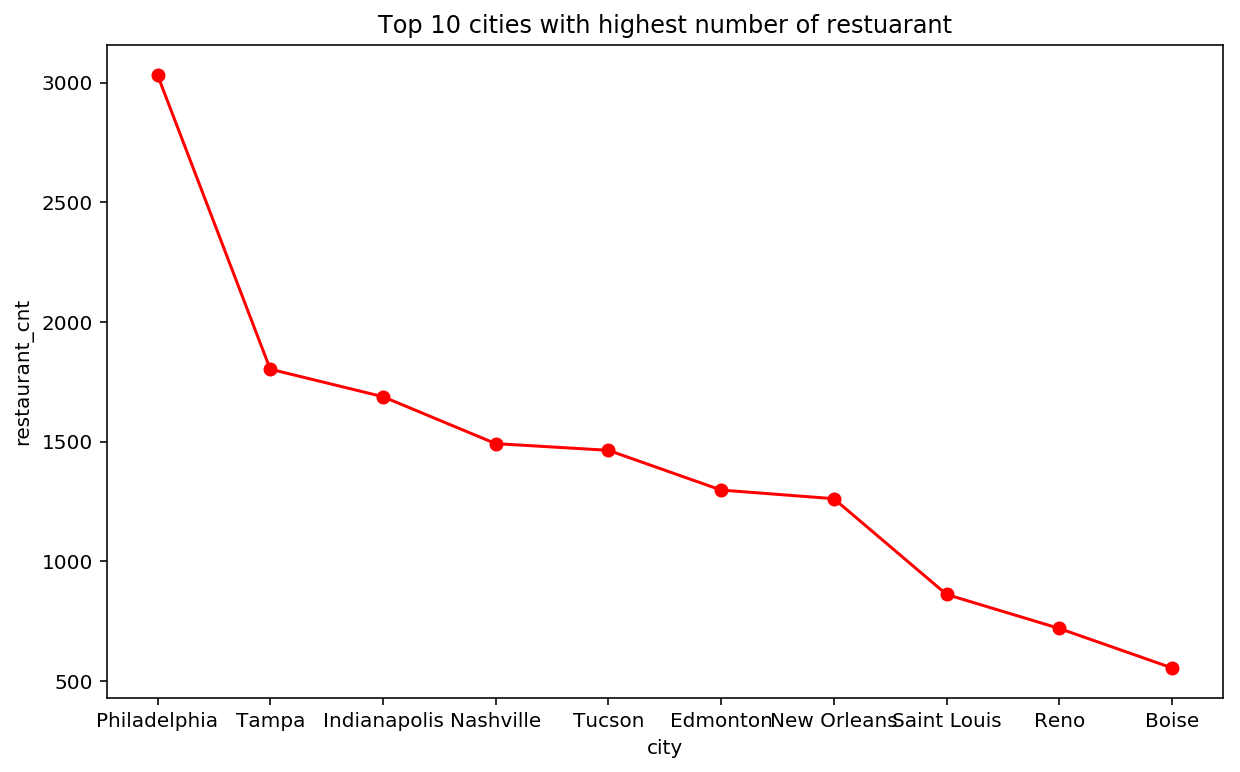

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(rest_top10df['city'], rest_top10df['restaurant_cnt'], color='red',marker = 'o')
plt.xlabel("city")
plt.ylabel("restaurant_cnt")
plt.title("Top 10 cities with highest number of restuarant")

plt.show()

Top 5 cities: Philadelphia, Tampa, Indianapolis, Nashville, Tucson

In [29]:
# Then select restaurants in top five cities

rest_top5 = spark.sql("SELECT * FROM rest \
                  where city in ('Philadelphia', 'Tampa', 'Indianapolis', 'Nashville', 'Tucson')")
rest_top5.show(5)

+-------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+-------------+------------------+-----------+------------+-----+-----+
|            address|          attributes|         business_id|          categories|        city|               hours|is_open|     latitude|    longitude|              name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+--------------------+------------+--------------------+-------+-------------+-------------+------------------+-----------+------------+-----+-----+
|        935 Race St|[,, u'none',,,,, ...|MTSW4McQd7CbVtyjq...|Restaurants, Food...|Philadelphia|[7:0-21:0, 7:0-20...|      1|   39.9555052|  -75.1555641|St Honore Pastries|      19107|          80|  4.0|   PA|
|2312 Dickerson Pike|[,, u'none',,,,,,...|bBDDEgkFA1Otx9Lfe...|Ice Cream & Froze...|   Nashville|[6:0-16:0, 0:0-0:...|      1|   36.2081024|  -86.7681696|  

In [30]:
df2 = rest_top5.toPandas()

In [31]:
rating_data=df2[['latitude','longitude','stars','review_count']]

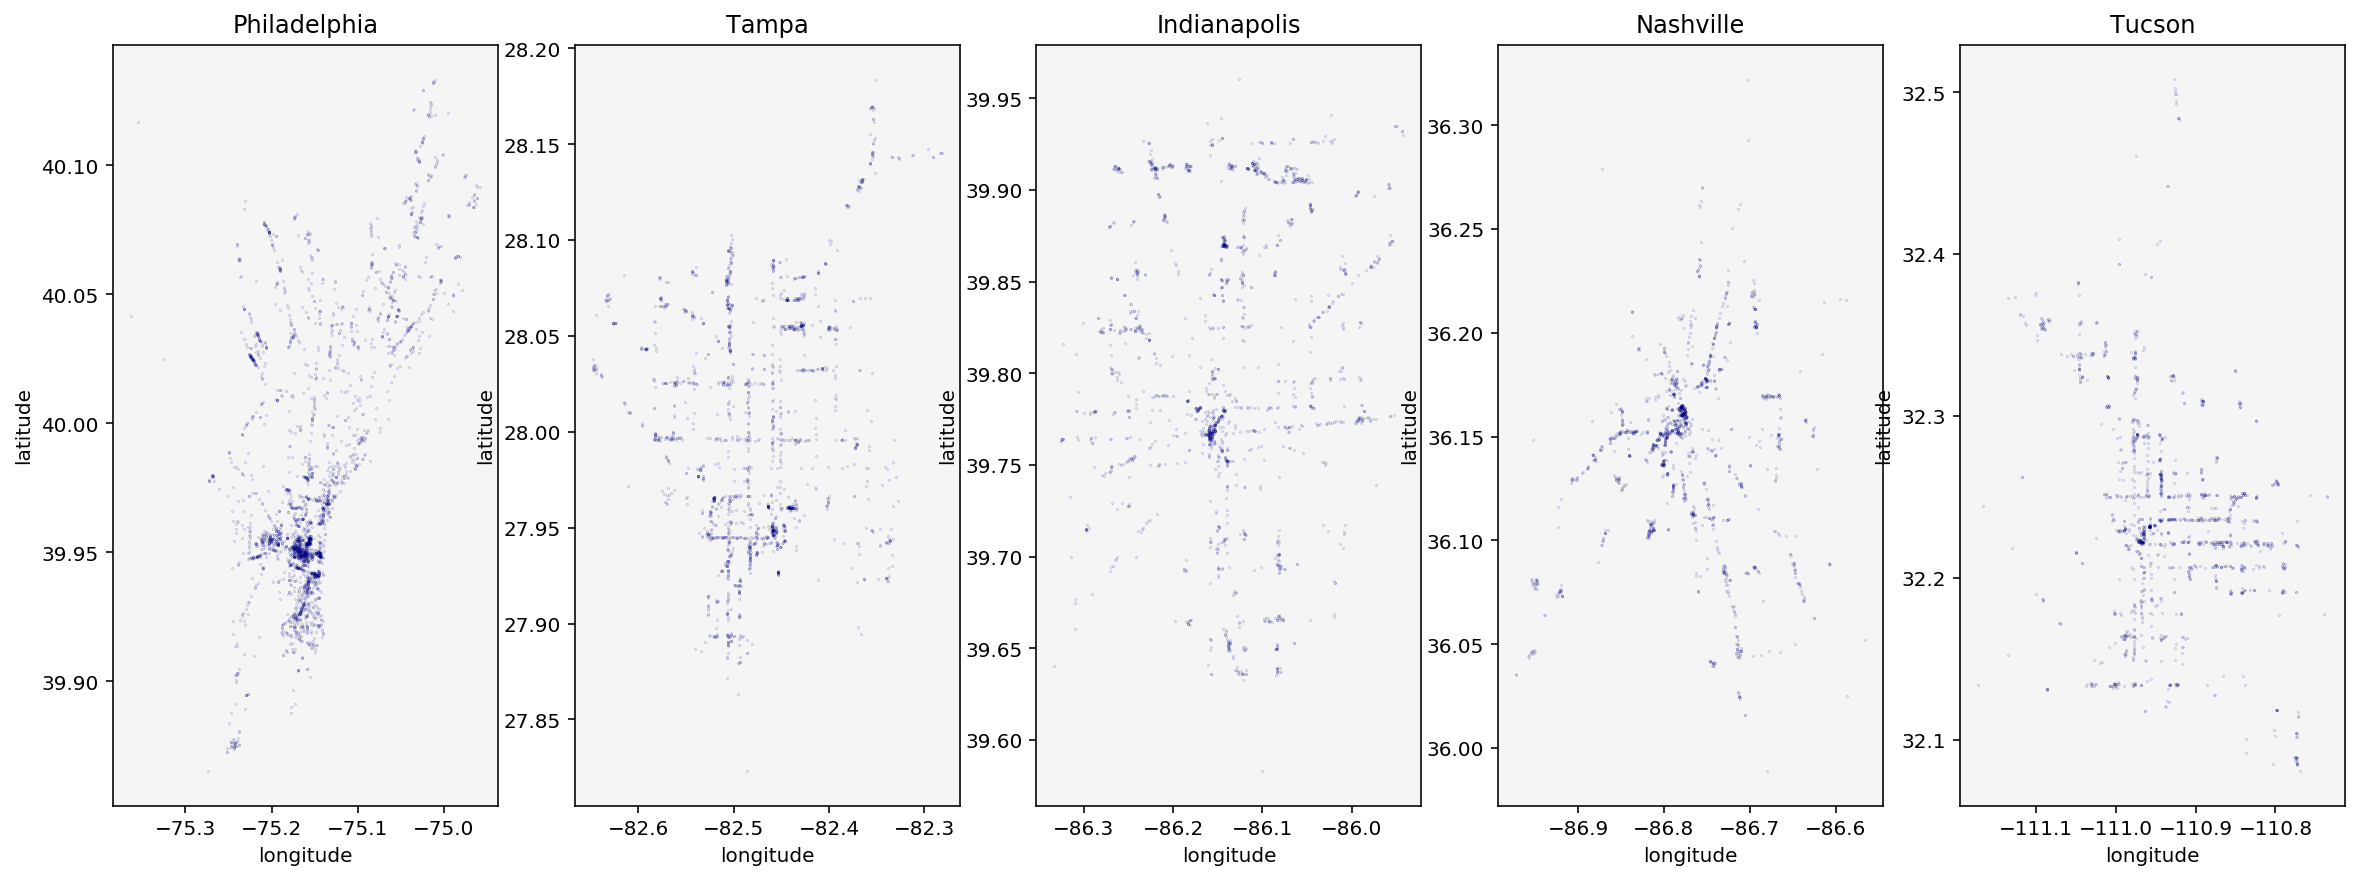

In [32]:
f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(20,7))

#a random point inside Philadelphia
lat = 39.9526
lon = -75.1652
#some adjustments to get the right pic
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5
#subset for Philadelphia
ratings_data_philadelphia=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]

#Facet scatter plot
ratings_data_philadelphia.plot(kind='scatter', x='longitude', y='latitude',
                color='navy', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Philadelphia")
ax1.set_facecolor('whitesmoke')

#a random point inside Tampa
lat = 27.9642
lon =  -82.4526
#some adjustments to get the right pic
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5
#subset for Tampa
ratings_data_tampa=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]

#Facet scatter plot
ratings_data_tampa.plot(kind='scatter', x='longitude', y='latitude',
                color='navy', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Tampa")
ax2.set_facecolor('whitesmoke')

#a random point inside Indianapolis
lat = 39.7910
lon = -86.1480
#some adjustments to get the right pic
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5
#subset for Indianapolis
ratings_data_indianapolis=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]

#Facet scatter plot
ratings_data_indianapolis.plot(kind='scatter', x='longitude', y='latitude',
                color='navy', 
                s=.02, alpha=.6, subplots=True, ax=ax3)
ax3.set_title("Indianapolis")
ax3.set_facecolor('whitesmoke')


#a random point inside Nashville
lat = 36.1745
lon = -86.7680
#some adjustments to get the right pic
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5
#subset for Nashville
ratings_data_nashville=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]

#Facet scatter plot
ratings_data_nashville.plot(kind='scatter', x='longitude', y='latitude',
                color='navy', 
                s=.02, alpha=.6, subplots=True, ax=ax4)
ax4.set_title("Nashville")
ax4.set_facecolor('whitesmoke')


#a random point inside Tucson
lat = 32.2535
lon = -110.9118
#some adjustments to get the right pic
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5
#subset for Tucson
ratings_data_tucson=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]

#Facet scatter plot
ratings_data_tucson.plot(kind='scatter', x='longitude', y='latitude',
                color='navy', 
                s=.02, alpha=.6, subplots=True, ax=ax5)
ax5.set_title("Tucson")
ax5.set_facecolor('whitesmoke')

We can see the reviewed restaurants are scattered in Tampa, Indianapolis, Nashville and Tucson while they are centralized in Philadelphia. 

In [33]:
rest_top5.createOrReplaceTempView("rest_top5")

In [34]:
# Then select restaurants in top five cities

review_cnt = spark.sql("SELECT city,sum(review_count) as review_count FROM rest_top5 \
                       group by city order by 2 desc")
review_cnt.show()

+------------+------------+
|        city|review_count|
+------------+------------+
|Philadelphia|      484576|
|   Nashville|      256181|
|       Tampa|      232489|
|      Tucson|      188364|
|Indianapolis|      182499|
+------------+------------+



In [35]:
review_cnt = review_cnt.toPandas()

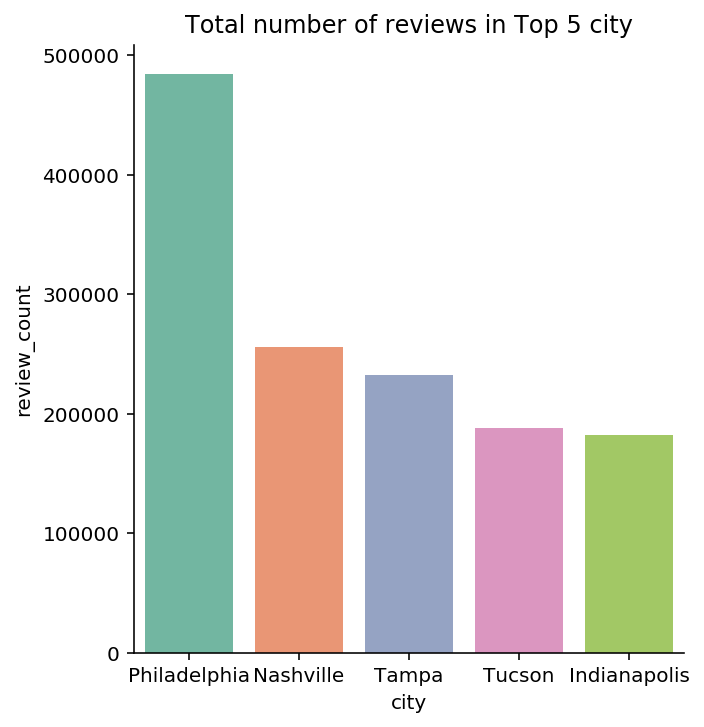

In [36]:
g = sns.catplot(x="city", y="review_count",data=review_cnt, kind="bar", palette="Set2").set(title='Total number of reviews in Top 5 city')
g.set_ylabels("review_count")

plt.show()

In [37]:
rest_cleaned = rest_top5.drop("address", "attributes","categories","hours","is_open","latitude","longitude",'postal_code','state')

In [38]:
print(review.printSchema())
review.show(5)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

None
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|Y

In [39]:
review = review.drop("user_id")

In [40]:
review = review.withColumnRenamed("stars","review_stars")

In [41]:
# join data
review_business = rest_cleaned.join(review, ["business_id"], 'inner')
review_business.show(5)

+--------------------+------------+-----------------+------------+-----+----+-------------------+-----+--------------------+------------+--------------------+------+
|         business_id|        city|             name|review_count|stars|cool|               date|funny|           review_id|review_stars|                text|useful|
+--------------------+------------+-----------------+------------+-----+----+-------------------+-----+--------------------+------------+--------------------+------+
|kxX2SOes4o-D3ZQBk...|Philadelphia|            Zaika|         181|  4.0|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|         5.0|Wow!  Yummy, diff...|     1|
|EQ-TZ2eeD_E0BHuvo...|Indianapolis|        Milktooth|        1379|  4.0|   0|2015-08-19 14:31:45|    0|l3Wk_mvAog6XANIuG...|         4.0|Locals recommende...|     0|
|otQS34_MymijPTdNB...|      Tucson|         BK Tacos|         492|  4.0|   0|2011-10-27 17:12:05|    2|UBp0zWyH60Hmw6Fsa...|         4.0|The bun makes the...|     0|
|BVn

In [42]:
review_business.createOrReplaceTempView("review_business")

In [43]:
year_review = spark.sql("SELECT substr(date, 1,4) as year, \
                       review_stars, \
                       count(1) as cnt\
                       FROM review_business \
                       where substr(date, 1,4) between 2017 and 2021 \
                       group by year,review_stars order by 1 desc, 2 desc")
year_review.show(year_review.count(),False)

+----+------------+-----+
|year|review_stars|cnt  |
+----+------------+-----+
|2021|5.0         |74855|
|2021|4.0         |23311|
|2021|3.0         |12241|
|2021|2.0         |9799 |
|2021|1.0         |20179|
|2020|5.0         |63775|
|2020|4.0         |20557|
|2020|3.0         |9588 |
|2020|2.0         |7348 |
|2020|1.0         |14878|
|2019|5.0         |98635|
|2019|4.0         |39609|
|2019|3.0         |19494|
|2019|2.0         |13975|
|2019|1.0         |23188|
|2018|5.0         |91746|
|2018|4.0         |40596|
|2018|3.0         |18988|
|2018|2.0         |13514|
|2018|1.0         |20550|
|2017|5.0         |74902|
|2017|4.0         |37835|
|2017|3.0         |17187|
|2017|2.0         |11739|
|2017|1.0         |16644|
+----+------------+-----+



In [44]:
year_review_df = year_review.toPandas()

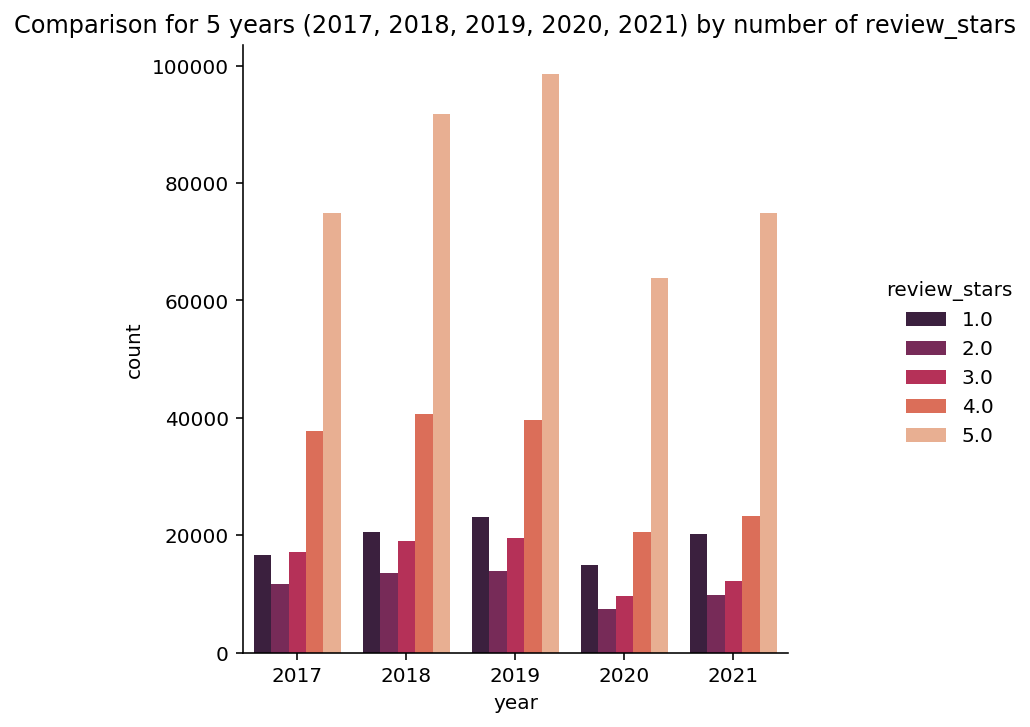

In [45]:
g = sns.catplot(x="year", y="cnt", hue="review_stars", data=year_review_df, kind="bar", palette="rocket").set(title='Comparison for 5 years (2017, 2018, 2019, 2020, 2021) by number of review_stars')
g.set_ylabels("count")

plt.show()

pandemic trend + focus on 5 star comments

In [46]:
pos_reviews = review_business.filter(review_business.review_stars == 5)
neg_reviews = review_business.filter(review_business.review_stars == 1)

In [47]:
#review_business = review_business.filter(review_business.review_stars == 5)

In [48]:
pos_reviews.groupBy('review_stars', 'city').count().orderBy('count', ascending = [0]).show()

+------------+------------+------+
|review_stars|        city| count|
+------------+------------+------+
|         5.0|Philadelphia|213779|
|         5.0|   Nashville|127221|
|         5.0|       Tampa|116555|
|         5.0|      Tucson| 88603|
|         5.0|Indianapolis| 88547|
+------------+------------+------+



In [49]:
neg_reviews.groupBy('review_stars', 'city').count().orderBy('count', ascending = [0]).show()

+------------+------------+-----+
|review_stars|        city|count|
+------------+------------+-----+
|         1.0|Philadelphia|45730|
|         1.0|       Tampa|27302|
|         1.0|   Nashville|26212|
|         1.0|      Tucson|25666|
|         1.0|Indianapolis|19287|
+------------+------------+-----+



In [102]:
neg_reviews.select('review_stars').distinct().collect()

[Row(review_stars=1.0)]

In [104]:
pos_reviews.select('review_stars').distinct().collect()

[Row(review_stars=5.0)]

In [119]:
s.select('review_stars').distinct().collect()

[Row(review_stars=1.0), Row(review_stars=5.0)]

In [50]:
five_star_review_city = pos_reviews.groupBy('review_stars', 'city').count().orderBy('count', ascending = [0]).toPandas()

In [51]:
one_star_review_city = neg_reviews.groupBy('review_stars', 'city').count().orderBy('count', ascending = [0]).toPandas()

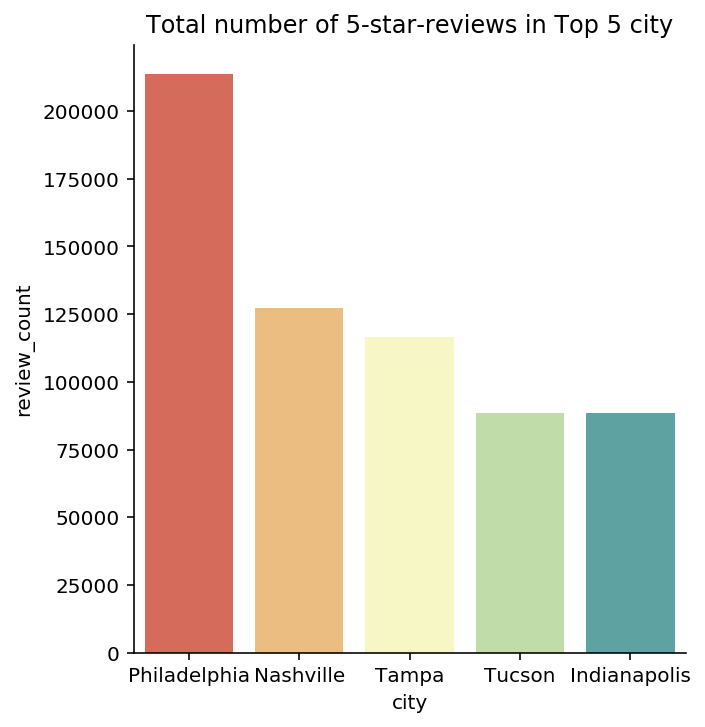

In [52]:
g = sns.catplot(x="city", y="count",data=five_star_review_city, kind = 'bar', palette="Spectral").set(title='Total number of 5-star-reviews in Top 5 city')
g.set_ylabels("review_count")

plt.show()

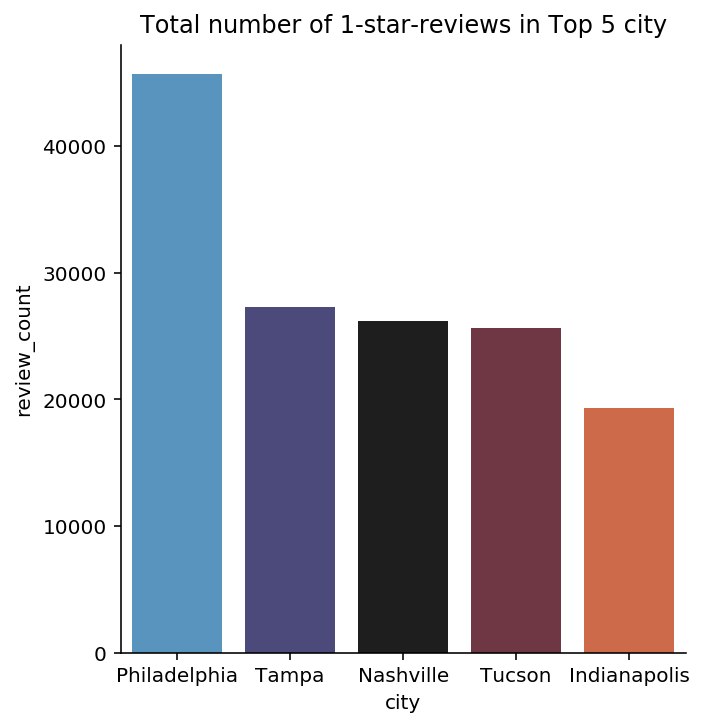

In [53]:
g = sns.catplot(x="city", y="count",data=one_star_review_city, kind = 'bar', palette="icefire").set(title='Total number of 1-star-reviews in Top 5 city')
g.set_ylabels("review_count")

plt.show()

In [107]:
# Union all the positive and negative reviews into the dataset named all_reviews
all_reviews = pos_reviews.union(neg_reviews)

In [55]:
all_reviews.show(1)

+--------------------+------------+-----+------------+-----+----+-------------------+-----+--------------------+------------+--------------------+------+
|         business_id|        city| name|review_count|stars|cool|               date|funny|           review_id|review_stars|                text|useful|
+--------------------+------------+-----+------------+-----+----+-------------------+-----+--------------------+------------+--------------------+------+
|kxX2SOes4o-D3ZQBk...|Philadelphia|Zaika|         181|  4.0|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|         5.0|Wow!  Yummy, diff...|     1|
+--------------------+------------+-----+------------+-----+----+-------------------+-----+--------------------+------------+--------------------+------+
only showing top 1 row



In [108]:
all_reviews.coalesce(1).write.mode('overwrite').option("inferSchema", "true").option('header', 'true').csv('hdfs:/user/ximanw/data/all_reviews.csv')
